# Building an LSTM model to predict the price of NABIL

## Setup

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [10]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Timestamp in Days")
    plt.ylabel("Rupees")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [11]:
# Read in data
nabil = pd.read_csv('../Data/NabilModifiedDate.csv')

# Convert series into datetime type
nabil['Date'] = pd.to_datetime(nabil['Date'])

# Save target series
series = nabil['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(nabil.Date == train_split_date)[0][0]
x_train = nabil.loc[nabil['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-01-03'
test_split_index = np.where(nabil.Date == test_split_date)[0][0]
x_test = nabil.loc[nabil['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = nabil.loc[(nabil['Date'] < test_split_date) & (nabil['Date'] > train_split_date)]['Close']

1479 1480 1663 1664 2144


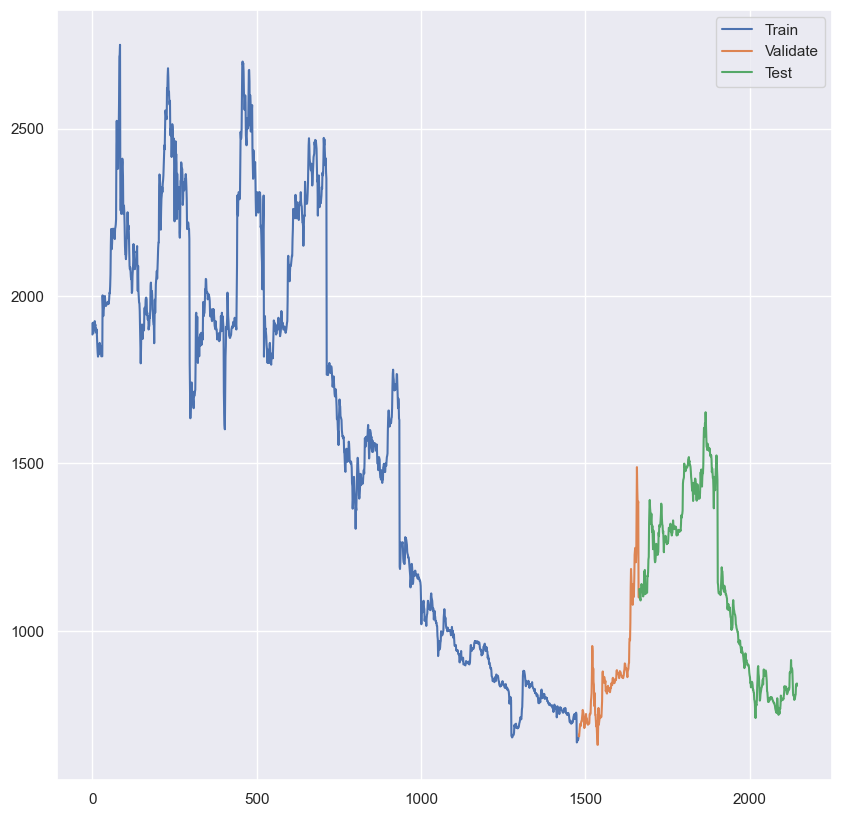

In [12]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
plt.savefig('../Images/LSTM/LSTM TRAIN TEST SPLIT')
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [13]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
nabil_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [14]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [15]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                      batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-5)  # Use the legacy Nadam optimizer

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])


Epoch 1/100
73/73 [==============================] - 3s 8ms/step - loss: 0.0966 - mae: 0.3670 - lr: 1.0000e-05
Epoch 2/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0710 - mae: 0.3077 - lr: 1.1220e-05
Epoch 3/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0426 - mae: 0.2304 - lr: 1.2589e-05
Epoch 4/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0175 - mae: 0.1439 - lr: 1.4125e-05
Epoch 5/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0050 - mae: 0.0770 - lr: 1.5849e-05
Epoch 6/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0559 - lr: 1.7783e-05
Epoch 7/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0536 - lr: 1.9953e-05
Epoch 8/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0521 - lr: 2.2387e-05
Epoch 9/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0506 - lr: 2.5119e-05
E

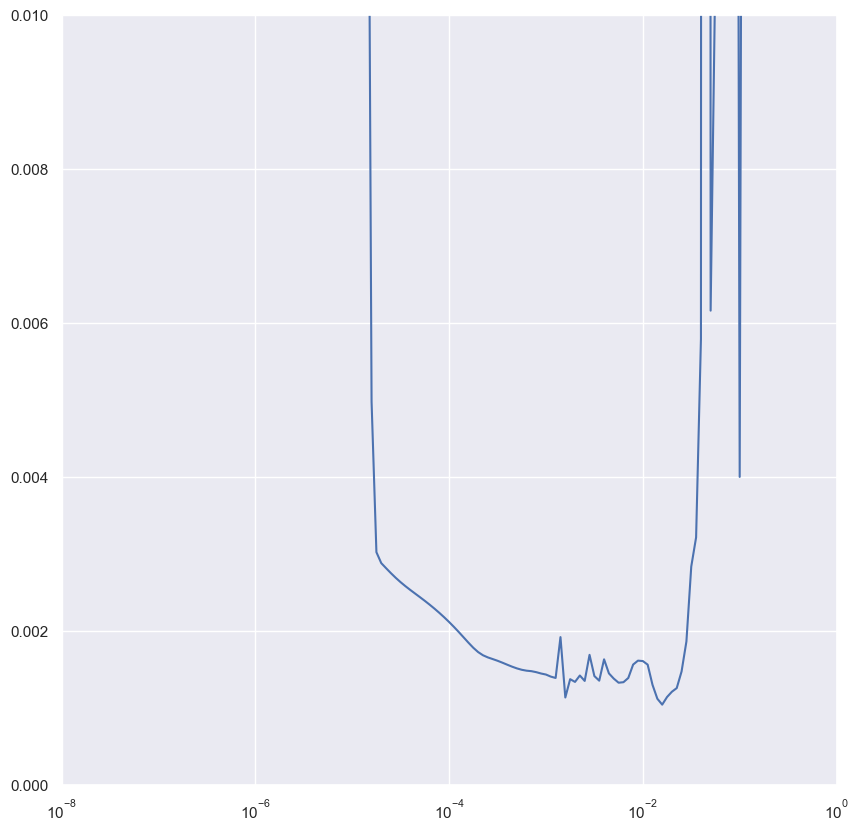

In [16]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])
plt.savefig('../Images/LSTM/LSTM LEARNING RATE PLOT')

## Build and Train LSTM Model

In [17]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'reset_states'):
            optimizer.reset_states()

# Reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# Create model
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                      batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
])

# Set optimizer (use the legacy Nadam optimizer)
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-4)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Reset states
reset_states = ResetStatesCallback()

# Set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# Fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])


Epoch 1/500
     45/Unknown - 3s 11ms/step - loss: 0.0870 - mae: 0.3254INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 7s 95ms/step - loss: 0.0801 - mae: 0.3040 - val_loss: 0.0017 - val_mae: 0.0527
Epoch 2/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0042 - mae: 0.0649INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0041 - mae: 0.0648 - val_loss: 0.0015 - val_mae: 0.0492
Epoch 3/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0037 - mae: 0.0589INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 0.0035 - mae: 0.0586 - val_loss: 0.0013 - val_mae: 0.0434
Epoch 4/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0035 - mae: 0.0561INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0033 - mae: 0.0555 - val_loss: 0.0011 - val_mae: 0.0390
Epoch 5/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0033 - mae: 0.0537INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0031 - mae: 0.0529 - val_loss: 0.0010 - val_mae: 0.0357
Epoch 6/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0516INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0029 - mae: 0.0506 - val_loss: 9.5083e-04 - val_mae: 0.0331
Epoch 7/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0030 - mae: 0.0498INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0028 - mae: 0.0487 - val_loss: 9.0000e-04 - val_mae: 0.0311
Epoch 8/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0481INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 78ms/step - loss: 0.0027 - mae: 0.0470 - val_loss: 8.6123e-04 - val_mae: 0.0296
Epoch 9/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0467INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0026 - mae: 0.0455 - val_loss: 8.3004e-04 - val_mae: 0.0283
Epoch 10/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0453INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 0.0025 - mae: 0.0441 - val_loss: 8.0373e-04 - val_mae: 0.0273
Epoch 11/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0441INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 0.0024 - mae: 0.0428 - val_loss: 7.8064e-04 - val_mae: 0.0265
Epoch 12/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0429INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0023 - mae: 0.0416 - val_loss: 7.5970e-04 - val_mae: 0.0257
Epoch 13/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0418INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0022 - mae: 0.0405 - val_loss: 7.4026e-04 - val_mae: 0.0251
Epoch 14/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0408INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 0.0021 - mae: 0.0394 - val_loss: 7.2186e-04 - val_mae: 0.0245
Epoch 15/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0398INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0021 - mae: 0.0384 - val_loss: 7.0421e-04 - val_mae: 0.0240
Epoch 16/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0388INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0020 - mae: 0.0374 - val_loss: 6.8711e-04 - val_mae: 0.0235
Epoch 17/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0378INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0019 - mae: 0.0364 - val_loss: 6.7044e-04 - val_mae: 0.0231
Epoch 18/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0369INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0019 - mae: 0.0355 - val_loss: 6.5415e-04 - val_mae: 0.0227
Epoch 19/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0359INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0018 - mae: 0.0345 - val_loss: 6.3824e-04 - val_mae: 0.0223
Epoch 20/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0350INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0018 - mae: 0.0336 - val_loss: 6.2278e-04 - val_mae: 0.0219
Epoch 21/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0342INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0017 - mae: 0.0328 - val_loss: 6.0786e-04 - val_mae: 0.0216
Epoch 22/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0334INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0016 - mae: 0.0320 - val_loss: 5.9365e-04 - val_mae: 0.0214
Epoch 23/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0328INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 5.8032e-04 - val_mae: 0.0212
Epoch 24/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0322INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0016 - mae: 0.0308 - val_loss: 5.6805e-04 - val_mae: 0.0210
Epoch 25/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0313INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0015 - mae: 0.0303 - val_loss: 5.5697e-04 - val_mae: 0.0209
Epoch 26/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0315INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 5.4716e-04 - val_mae: 0.0207
Epoch 27/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0319INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 5.3864e-04 - val_mae: 0.0206
Epoch 28/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0312INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 5.3132e-04 - val_mae: 0.0206
Epoch 29/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0312INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 5.2504e-04 - val_mae: 0.0205
Epoch 30/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0311INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 5.1961e-04 - val_mae: 0.0204
Epoch 31/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0311INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0015 - mae: 0.0294 - val_loss: 5.1482e-04 - val_mae: 0.0204
Epoch 32/500
48/49 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0299INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0014 - mae: 0.0294 - val_loss: 5.1050e-04 - val_mae: 0.0203
Epoch 33/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0309INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0014 - mae: 0.0293 - val_loss: 5.0648e-04 - val_mae: 0.0202
Epoch 34/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0308INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 5.0267e-04 - val_mae: 0.0202
Epoch 35/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0307INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0014 - mae: 0.0291 - val_loss: 4.9898e-04 - val_mae: 0.0201
Epoch 36/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0306INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0014 - mae: 0.0289 - val_loss: 4.9537e-04 - val_mae: 0.0200
Epoch 37/500
48/49 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0293INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 4.9181e-04 - val_mae: 0.0200
Epoch 38/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0303INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0014 - mae: 0.0287 - val_loss: 4.8829e-04 - val_mae: 0.0199
Epoch 39/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0301INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0013 - mae: 0.0285 - val_loss: 4.8480e-04 - val_mae: 0.0198
Epoch 40/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0300INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0013 - mae: 0.0284 - val_loss: 4.8134e-04 - val_mae: 0.0197
Epoch 41/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0298INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0013 - mae: 0.0282 - val_loss: 4.7792e-04 - val_mae: 0.0197
Epoch 42/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0291INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0013 - mae: 0.0281 - val_loss: 4.7454e-04 - val_mae: 0.0196
Epoch 43/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0300INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 4.7119e-04 - val_mae: 0.0195
Epoch 44/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0293INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 4.6789e-04 - val_mae: 0.0194
Epoch 45/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0292INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 4.6462e-04 - val_mae: 0.0193
Epoch 46/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0290INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0012 - mae: 0.0274 - val_loss: 4.6140e-04 - val_mae: 0.0193
Epoch 47/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0294INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0012 - mae: 0.0273 - val_loss: 4.5823e-04 - val_mae: 0.0192
Epoch 48/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0286INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 4.5510e-04 - val_mae: 0.0191
Epoch 49/500
48/49 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0274INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 4.5202e-04 - val_mae: 0.0190
Epoch 50/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0283INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 0.0012 - mae: 0.0268 - val_loss: 4.4897e-04 - val_mae: 0.0189
Epoch 51/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0287INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 4.4598e-04 - val_mae: 0.0189
Epoch 52/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0280INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 4.4302e-04 - val_mae: 0.0188
Epoch 53/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0278INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0011 - mae: 0.0263 - val_loss: 4.4011e-04 - val_mae: 0.0187
Epoch 54/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0277INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0011 - mae: 0.0262 - val_loss: 4.3724e-04 - val_mae: 0.0187
Epoch 55/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0280INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 0.0011 - mae: 0.0260 - val_loss: 4.3440e-04 - val_mae: 0.0186
Epoch 56/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0273INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0011 - mae: 0.0259 - val_loss: 4.3160e-04 - val_mae: 0.0185
Epoch 57/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0272INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0011 - mae: 0.0257 - val_loss: 4.2884e-04 - val_mae: 0.0185
Epoch 58/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0011 - mae: 0.0256 - val_loss: 4.2612e-04 - val_mae: 0.0184
Epoch 59/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0269INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 4.2343e-04 - val_mae: 0.0183
Epoch 60/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0262INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 4.2078e-04 - val_mae: 0.0183
Epoch 61/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0266INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 4.1816e-04 - val_mae: 0.0182
Epoch 62/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 0.0010 - mae: 0.0250 - val_loss: 4.1558e-04 - val_mae: 0.0181
Epoch 63/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0268INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 0.0010 - mae: 0.0249 - val_loss: 4.1303e-04 - val_mae: 0.0181
Epoch 64/500
47/49 [===========================>..] - ETA: 65:41:54 - loss: 0.0011 - mae: 0.0256 INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5439847s 113330s/step - loss: 0.0010 - mae: 0.0247 - val_loss: 4.1052e-04 - val_mae: 0.0180
Epoch 65/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 4.0805e-04 - val_mae: 0.0180
Epoch 66/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0258INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 94ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 4.0561e-04 - val_mae: 0.0179
Epoch 67/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 9.9028e-04 - mae: 0.0243 - val_loss: 4.0322e-04 - val_mae: 0.0178
Epoch 68/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0256INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 9.7983e-04 - mae: 0.0242 - val_loss: 4.0086e-04 - val_mae: 0.0178
Epoch 69/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 9.6950e-04 - mae: 0.0241 - val_loss: 3.9855e-04 - val_mae: 0.0177
Epoch 70/500
48/49 [============================>.] - ETA: 0s - loss: 9.7898e-04 - mae: 0.0243INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 9.5929e-04 - mae: 0.0239 - val_loss: 3.9628e-04 - val_mae: 0.0177
Epoch 71/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0251INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 9.4921e-04 - mae: 0.0238 - val_loss: 3.9407e-04 - val_mae: 0.0176
Epoch 72/500
49/49 [==============================] - ETA: 0s - loss: 9.3925e-04 - mae: 0.0237INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 100ms/step - loss: 9.3925e-04 - mae: 0.0237 - val_loss: 3.9190e-04 - val_mae: 0.0176
Epoch 73/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0253INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 9.2942e-04 - mae: 0.0236 - val_loss: 3.8978e-04 - val_mae: 0.0175
Epoch 74/500
46/49 [===========================>..] - ETA: 0s - loss: 9.7911e-04 - mae: 0.0248INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 9.1972e-04 - mae: 0.0234 - val_loss: 3.8772e-04 - val_mae: 0.0175
Epoch 75/500
45/49 [==========================>...] - ETA: 0s - loss: 9.9008e-04 - mae: 0.0251INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 9.1017e-04 - mae: 0.0233 - val_loss: 3.8572e-04 - val_mae: 0.0174
Epoch 76/500
45/49 [==========================>...] - ETA: 0s - loss: 9.7984e-04 - mae: 0.0249INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 9.0075e-04 - mae: 0.0232 - val_loss: 3.8379e-04 - val_mae: 0.0174
Epoch 77/500
46/49 [===========================>..] - ETA: 0s - loss: 9.4903e-04 - mae: 0.0244INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 8.9148e-04 - mae: 0.0231 - val_loss: 3.8191e-04 - val_mae: 0.0173
Epoch 78/500
46/49 [===========================>..] - ETA: 0s - loss: 9.3933e-04 - mae: 0.0242INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 8.8237e-04 - mae: 0.0230 - val_loss: 3.8011e-04 - val_mae: 0.0173
Epoch 79/500
46/49 [===========================>..] - ETA: 0s - loss: 9.2980e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 8.7342e-04 - mae: 0.0228 - val_loss: 3.7839e-04 - val_mae: 0.0173
Epoch 80/500
49/49 [==============================] - ETA: 0s - loss: 8.6464e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 8.6464e-04 - mae: 0.0227 - val_loss: 3.7674e-04 - val_mae: 0.0172
Epoch 81/500
45/49 [==========================>...] - ETA: 0s - loss: 9.3117e-04 - mae: 0.0243INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 8.5604e-04 - mae: 0.0226 - val_loss: 3.7517e-04 - val_mae: 0.0172
Epoch 82/500
45/49 [==========================>...] - ETA: 0s - loss: 9.2201e-04 - mae: 0.0242INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 8.4762e-04 - mae: 0.0225 - val_loss: 3.7368e-04 - val_mae: 0.0171
Epoch 83/500
46/49 [===========================>..] - ETA: 0s - loss: 8.9357e-04 - mae: 0.0237INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 8.3940e-04 - mae: 0.0224 - val_loss: 3.7229e-04 - val_mae: 0.0171
Epoch 84/500
49/49 [==============================] - ETA: 0s - loss: 8.3138e-04 - mae: 0.0223INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 8.3138e-04 - mae: 0.0223 - val_loss: 3.7098e-04 - val_mae: 0.0171
Epoch 85/500
46/49 [===========================>..] - ETA: 0s - loss: 8.7673e-04 - mae: 0.0235INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 97ms/step - loss: 8.2358e-04 - mae: 0.0223 - val_loss: 3.6977e-04 - val_mae: 0.0170
Epoch 86/500
49/49 [==============================] - ETA: 0s - loss: 8.1600e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 8.1600e-04 - mae: 0.0222 - val_loss: 3.6865e-04 - val_mae: 0.0170
Epoch 87/500
45/49 [==========================>...] - ETA: 0s - loss: 8.7960e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 8.0865e-04 - mae: 0.0221 - val_loss: 3.6762e-04 - val_mae: 0.0170
Epoch 88/500
45/49 [==========================>...] - ETA: 0s - loss: 8.7185e-04 - mae: 0.0237INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 8.0153e-04 - mae: 0.0220 - val_loss: 3.6669e-04 - val_mae: 0.0170
Epoch 89/500
47/49 [===========================>..] - ETA: 0s - loss: 8.2801e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 7.9467e-04 - mae: 0.0219 - val_loss: 3.6585e-04 - val_mae: 0.0169
Epoch 90/500
48/49 [============================>.] - ETA: 0s - loss: 8.0422e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 96ms/step - loss: 7.8805e-04 - mae: 0.0219 - val_loss: 3.6509e-04 - val_mae: 0.0169
Epoch 91/500
45/49 [==========================>...] - ETA: 0s - loss: 8.5025e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 7.8168e-04 - mae: 0.0218 - val_loss: 3.6443e-04 - val_mae: 0.0169
Epoch 92/500
46/49 [===========================>..] - ETA: 0s - loss: 8.2560e-04 - mae: 0.0229INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 7.7557e-04 - mae: 0.0217 - val_loss: 3.6384e-04 - val_mae: 0.0169
Epoch 93/500
47/49 [===========================>..] - ETA: 0s - loss: 8.0199e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 7.6971e-04 - mae: 0.0217 - val_loss: 3.6334e-04 - val_mae: 0.0169
Epoch 94/500
46/49 [===========================>..] - ETA: 0s - loss: 8.1339e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 7.6410e-04 - mae: 0.0216 - val_loss: 3.6292e-04 - val_mae: 0.0169
Epoch 95/500
46/49 [===========================>..] - ETA: 0s - loss: 8.0768e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 7.5874e-04 - mae: 0.0216 - val_loss: 3.6258e-04 - val_mae: 0.0169
Epoch 96/500
46/49 [===========================>..] - ETA: 0s - loss: 8.0225e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 7.5364e-04 - mae: 0.0215 - val_loss: 3.6235e-04 - val_mae: 0.0169
Epoch 97/500
46/49 [===========================>..] - ETA: 0s - loss: 7.9708e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 7.4879e-04 - mae: 0.0215 - val_loss: 3.6222e-04 - val_mae: 0.0169
Epoch 98/500
49/49 [==============================] - 1s 13ms/step - loss: 7.4423e-04 - mae: 0.0215 - val_loss: 3.6224e-04 - val_mae: 0.0169
Epoch 99/500
49/49 [==============================] - 1s 13ms/step - loss: 7.3999e-04 - mae: 0.0215 - val_loss: 3.6244e-04 - val_mae: 0.0169
Epoch 100/500
49/49 [==============================] - 1s 13ms/step - loss: 7.3621e-04 - mae: 0.0215 - val_loss: 3.6287e-04 - val_mae: 0.0170
Epoch 101/500
49/49 [==============================] - 1s 12ms/step - loss: 7.3323e-04 - mae: 0.0215 - val_loss: 3.6355e-04 - val_mae: 0.0170
Epoch 102/500
49/49 [==============================] - 1s 12ms/step - loss: 7.3091e-04 - mae: 0.0214 - val_loss: 3.6426e-04 - val_mae: 0.0171
Epoch 103/500
46/49 [===========================>..] - ETA: 0s - loss: 7.6851e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 7.2201e-04 - mae: 0.0212 - val_loss: 3.6149e-04 - val_mae: 0.0170
Epoch 104/500
46/49 [===========================>..] - ETA: 0s - loss: 7.6131e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 7.1527e-04 - mae: 0.0210 - val_loss: 3.5817e-04 - val_mae: 0.0170
Epoch 105/500
46/49 [===========================>..] - ETA: 0s - loss: 7.5935e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 7.1344e-04 - mae: 0.0210 - val_loss: 3.5642e-04 - val_mae: 0.0170
Epoch 106/500
48/49 [============================>.] - ETA: 0s - loss: 7.2164e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 7.0715e-04 - mae: 0.0209 - val_loss: 3.5270e-04 - val_mae: 0.0169
Epoch 107/500
49/49 [==============================] - 1s 12ms/step - loss: 7.1148e-04 - mae: 0.0211 - val_loss: 3.5305e-04 - val_mae: 0.0169
Epoch 108/500
49/49 [==============================] - ETA: 0s - loss: 6.9854e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 96ms/step - loss: 6.9854e-04 - mae: 0.0207 - val_loss: 3.4600e-04 - val_mae: 0.0166
Epoch 109/500
49/49 [==============================] - 1s 20ms/step - loss: 7.2384e-04 - mae: 0.0214 - val_loss: 3.5404e-04 - val_mae: 0.0170
Epoch 110/500
49/49 [==============================] - ETA: 0s - loss: 6.8542e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 103ms/step - loss: 6.8542e-04 - mae: 0.0204 - val_loss: 3.3688e-04 - val_mae: 0.0162
Epoch 111/500
49/49 [==============================] - 1s 14ms/step - loss: 7.1112e-04 - mae: 0.0209 - val_loss: 3.4252e-04 - val_mae: 0.0165
Epoch 112/500
49/49 [==============================] - 1s 12ms/step - loss: 6.9192e-04 - mae: 0.0206 - val_loss: 3.3704e-04 - val_mae: 0.0162
Epoch 113/500
49/49 [==============================] - 1s 12ms/step - loss: 7.0593e-04 - mae: 0.0209 - val_loss: 3.3868e-04 - val_mae: 0.0163
Epoch 114/500
46/49 [===========================>..] - ETA: 0s - loss: 7.3776e-04 - mae: 0.0218INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 6.9309e-04 - mae: 0.0207 - val_loss: 3.3494e-04 - val_mae: 0.0161
Epoch 115/500
49/49 [==============================] - 1s 12ms/step - loss: 6.9376e-04 - mae: 0.0207 - val_loss: 3.3509e-04 - val_mae: 0.0162
Epoch 116/500
46/49 [===========================>..] - ETA: 0s - loss: 7.2951e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 6.8535e-04 - mae: 0.0206 - val_loss: 3.3352e-04 - val_mae: 0.0161
Epoch 117/500
46/49 [===========================>..] - ETA: 0s - loss: 7.2731e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 6.8329e-04 - mae: 0.0206 - val_loss: 3.3258e-04 - val_mae: 0.0161
Epoch 118/500
46/49 [===========================>..] - ETA: 0s - loss: 7.2190e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 6.7820e-04 - mae: 0.0205 - val_loss: 3.3107e-04 - val_mae: 0.0160
Epoch 119/500
46/49 [===========================>..] - ETA: 0s - loss: 7.1892e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 6.7540e-04 - mae: 0.0205 - val_loss: 3.3018e-04 - val_mae: 0.0160
Epoch 120/500
46/49 [===========================>..] - ETA: 0s - loss: 7.1472e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 6.7145e-04 - mae: 0.0204 - val_loss: 3.2902e-04 - val_mae: 0.0160
Epoch 121/500
46/49 [===========================>..] - ETA: 0s - loss: 7.1174e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 97ms/step - loss: 6.6865e-04 - mae: 0.0204 - val_loss: 3.2818e-04 - val_mae: 0.0159
Epoch 122/500
47/49 [===========================>..] - ETA: 0s - loss: 6.9332e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 96ms/step - loss: 6.6544e-04 - mae: 0.0203 - val_loss: 3.2723e-04 - val_mae: 0.0159
Epoch 123/500
46/49 [===========================>..] - ETA: 0s - loss: 7.0537e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 6.6266e-04 - mae: 0.0203 - val_loss: 3.2644e-04 - val_mae: 0.0159
Epoch 124/500
46/49 [===========================>..] - ETA: 0s - loss: 7.0229e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 6.5977e-04 - mae: 0.0203 - val_loss: 3.2560e-04 - val_mae: 0.0158
Epoch 125/500
46/49 [===========================>..] - ETA: 0s - loss: 6.9939e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 6.5705e-04 - mae: 0.0203 - val_loss: 3.2482e-04 - val_mae: 0.0158
Epoch 126/500
46/49 [===========================>..] - ETA: 0s - loss: 6.9649e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 6.5432e-04 - mae: 0.0202 - val_loss: 3.2401e-04 - val_mae: 0.0158
Epoch 127/500
46/49 [===========================>..] - ETA: 0s - loss: 6.9367e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 6.5167e-04 - mae: 0.0202 - val_loss: 3.2321e-04 - val_mae: 0.0158
Epoch 128/500
46/49 [===========================>..] - ETA: 0s - loss: 6.9088e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 6.4905e-04 - mae: 0.0202 - val_loss: 3.2239e-04 - val_mae: 0.0157
Epoch 129/500
46/49 [===========================>..] - ETA: 0s - loss: 6.8813e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 6.4646e-04 - mae: 0.0202 - val_loss: 3.2157e-04 - val_mae: 0.0157
Epoch 130/500
46/49 [===========================>..] - ETA: 0s - loss: 6.8541e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 6.4391e-04 - mae: 0.0202 - val_loss: 3.2072e-04 - val_mae: 0.0157
Epoch 131/500
46/49 [===========================>..] - ETA: 0s - loss: 6.8271e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 6.4137e-04 - mae: 0.0201 - val_loss: 3.1986e-04 - val_mae: 0.0156
Epoch 132/500
46/49 [===========================>..] - ETA: 0s - loss: 6.8002e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 6.3885e-04 - mae: 0.0201 - val_loss: 3.1896e-04 - val_mae: 0.0156
Epoch 133/500
46/49 [===========================>..] - ETA: 0s - loss: 6.7734e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 6.3633e-04 - mae: 0.0201 - val_loss: 3.1805e-04 - val_mae: 0.0156
Epoch 134/500
46/49 [===========================>..] - ETA: 0s - loss: 6.7465e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 6.3380e-04 - mae: 0.0201 - val_loss: 3.1711e-04 - val_mae: 0.0156
Epoch 135/500
46/49 [===========================>..] - ETA: 0s - loss: 6.7195e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 6.3127e-04 - mae: 0.0200 - val_loss: 3.1615e-04 - val_mae: 0.0155
Epoch 136/500
45/49 [==========================>...] - ETA: 0s - loss: 6.8379e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 94ms/step - loss: 6.2873e-04 - mae: 0.0200 - val_loss: 3.1516e-04 - val_mae: 0.0155
Epoch 137/500
46/49 [===========================>..] - ETA: 0s - loss: 6.6652e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 6.2616e-04 - mae: 0.0200 - val_loss: 3.1416e-04 - val_mae: 0.0155
Epoch 138/500
46/49 [===========================>..] - ETA: 0s - loss: 6.6377e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 6.2359e-04 - mae: 0.0200 - val_loss: 3.1313e-04 - val_mae: 0.0154
Epoch 139/500
46/49 [===========================>..] - ETA: 0s - loss: 6.6101e-04 - mae: 0.0210INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 6.2100e-04 - mae: 0.0199 - val_loss: 3.1210e-04 - val_mae: 0.0154
Epoch 140/500
47/49 [===========================>..] - ETA: 0s - loss: 6.4430e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 99ms/step - loss: 6.1839e-04 - mae: 0.0199 - val_loss: 3.1105e-04 - val_mae: 0.0154
Epoch 141/500
46/49 [===========================>..] - ETA: 0s - loss: 6.5544e-04 - mae: 0.0210INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 6.1577e-04 - mae: 0.0199 - val_loss: 3.1001e-04 - val_mae: 0.0153
Epoch 142/500
48/49 [============================>.] - ETA: 0s - loss: 6.2573e-04 - mae: 0.0202INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 6.1314e-04 - mae: 0.0198 - val_loss: 3.0896e-04 - val_mae: 0.0153
Epoch 143/500
46/49 [===========================>..] - ETA: 0s - loss: 6.4983e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 6.1050e-04 - mae: 0.0198 - val_loss: 3.0791e-04 - val_mae: 0.0153
Epoch 144/500
46/49 [===========================>..] - ETA: 0s - loss: 6.4702e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 6.0785e-04 - mae: 0.0198 - val_loss: 3.0687e-04 - val_mae: 0.0152
Epoch 145/500
49/49 [==============================] - ETA: 0s - loss: 6.0520e-04 - mae: 0.0198INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 99ms/step - loss: 6.0520e-04 - mae: 0.0198 - val_loss: 3.0584e-04 - val_mae: 0.0152
Epoch 146/500
49/49 [==============================] - ETA: 0s - loss: 6.0254e-04 - mae: 0.0197INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 94ms/step - loss: 6.0254e-04 - mae: 0.0197 - val_loss: 3.0481e-04 - val_mae: 0.0152
Epoch 147/500
47/49 [===========================>..] - ETA: 0s - loss: 6.2499e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 100ms/step - loss: 5.9986e-04 - mae: 0.0197 - val_loss: 3.0380e-04 - val_mae: 0.0151
Epoch 148/500
46/49 [===========================>..] - ETA: 0s - loss: 6.3564e-04 - mae: 0.0208INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.9717e-04 - mae: 0.0197 - val_loss: 3.0280e-04 - val_mae: 0.0151
Epoch 149/500
46/49 [===========================>..] - ETA: 0s - loss: 6.3274e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 5.9444e-04 - mae: 0.0196 - val_loss: 3.0181e-04 - val_mae: 0.0151
Epoch 150/500
46/49 [===========================>..] - ETA: 0s - loss: 6.2979e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.9167e-04 - mae: 0.0196 - val_loss: 3.0081e-04 - val_mae: 0.0150
Epoch 151/500
45/49 [==========================>...] - ETA: 0s - loss: 6.4038e-04 - mae: 0.0210INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 5.8883e-04 - mae: 0.0196 - val_loss: 2.9981e-04 - val_mae: 0.0150
Epoch 152/500
46/49 [===========================>..] - ETA: 0s - loss: 6.2365e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 5.8590e-04 - mae: 0.0195 - val_loss: 2.9877e-04 - val_mae: 0.0150
Epoch 153/500
46/49 [===========================>..] - ETA: 0s - loss: 6.2040e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.8285e-04 - mae: 0.0195 - val_loss: 2.9771e-04 - val_mae: 0.0149
Epoch 154/500
49/49 [==============================] - ETA: 0s - loss: 5.7965e-04 - mae: 0.0194INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 5.7965e-04 - mae: 0.0194 - val_loss: 2.9658e-04 - val_mae: 0.0149
Epoch 155/500
46/49 [===========================>..] - ETA: 0s - loss: 6.1337e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 5.7625e-04 - mae: 0.0194 - val_loss: 2.9537e-04 - val_mae: 0.0148
Epoch 156/500
49/49 [==============================] - ETA: 0s - loss: 5.7263e-04 - mae: 0.0193INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 95ms/step - loss: 5.7263e-04 - mae: 0.0193 - val_loss: 2.9407e-04 - val_mae: 0.0148
Epoch 157/500
45/49 [==========================>...] - ETA: 0s - loss: 6.1852e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 110ms/step - loss: 5.6874e-04 - mae: 0.0192 - val_loss: 2.9265e-04 - val_mae: 0.0147
Epoch 158/500
48/49 [============================>.] - ETA: 0s - loss: 5.7612e-04 - mae: 0.0194INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 5.6455e-04 - mae: 0.0191 - val_loss: 2.9109e-04 - val_mae: 0.0147
Epoch 159/500
46/49 [===========================>..] - ETA: 0s - loss: 5.9610e-04 - mae: 0.0201INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 5.6004e-04 - mae: 0.0190 - val_loss: 2.8938e-04 - val_mae: 0.0146
Epoch 160/500
46/49 [===========================>..] - ETA: 0s - loss: 5.9094e-04 - mae: 0.0199INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 5.5520e-04 - mae: 0.0189 - val_loss: 2.8751e-04 - val_mae: 0.0145
Epoch 161/500
47/49 [===========================>..] - ETA: 0s - loss: 5.7303e-04 - mae: 0.0194INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 5.5002e-04 - mae: 0.0188 - val_loss: 2.8548e-04 - val_mae: 0.0145
Epoch 162/500
46/49 [===========================>..] - ETA: 0s - loss: 5.7959e-04 - mae: 0.0196INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 5.4454e-04 - mae: 0.0186 - val_loss: 2.8329e-04 - val_mae: 0.0144
Epoch 163/500
45/49 [==========================>...] - ETA: 0s - loss: 5.8594e-04 - mae: 0.0198INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.3881e-04 - mae: 0.0185 - val_loss: 2.8096e-04 - val_mae: 0.0143
Epoch 164/500
46/49 [===========================>..] - ETA: 0s - loss: 5.6716e-04 - mae: 0.0193INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 5.3290e-04 - mae: 0.0183 - val_loss: 2.7851e-04 - val_mae: 0.0142
Epoch 165/500
47/49 [===========================>..] - ETA: 0s - loss: 5.4890e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 5.2689e-04 - mae: 0.0181 - val_loss: 2.7600e-04 - val_mae: 0.0141
Epoch 166/500
49/49 [==============================] - ETA: 0s - loss: 5.2091e-04 - mae: 0.0179INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 5.2091e-04 - mae: 0.0179 - val_loss: 2.7345e-04 - val_mae: 0.0140
Epoch 167/500
48/49 [============================>.] - ETA: 0s - loss: 5.2555e-04 - mae: 0.0181INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.1505e-04 - mae: 0.0178 - val_loss: 2.7092e-04 - val_mae: 0.0139
Epoch 168/500
46/49 [===========================>..] - ETA: 0s - loss: 5.4209e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 5.0940e-04 - mae: 0.0176 - val_loss: 2.6846e-04 - val_mae: 0.0138
Epoch 169/500
45/49 [==========================>...] - ETA: 0s - loss: 5.4801e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 5.0404e-04 - mae: 0.0174 - val_loss: 2.6610e-04 - val_mae: 0.0137
Epoch 170/500
45/49 [==========================>...] - ETA: 0s - loss: 5.4251e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 4.9901e-04 - mae: 0.0173 - val_loss: 2.6387e-04 - val_mae: 0.0136
Epoch 171/500
46/49 [===========================>..] - ETA: 0s - loss: 5.2599e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 4.9432e-04 - mae: 0.0171 - val_loss: 2.6181e-04 - val_mae: 0.0135
Epoch 172/500
47/49 [===========================>..] - ETA: 0s - loss: 5.1037e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 103ms/step - loss: 4.8999e-04 - mae: 0.0170 - val_loss: 2.5994e-04 - val_mae: 0.0134
Epoch 173/500
45/49 [==========================>...] - ETA: 0s - loss: 5.2832e-04 - mae: 0.0181INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 4.8600e-04 - mae: 0.0169 - val_loss: 2.5825e-04 - val_mae: 0.0134
Epoch 174/500
46/49 [===========================>..] - ETA: 0s - loss: 5.1321e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 4.8235e-04 - mae: 0.0168 - val_loss: 2.5678e-04 - val_mae: 0.0133
Epoch 175/500
47/49 [===========================>..] - ETA: 0s - loss: 4.9893e-04 - mae: 0.0173INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 4.7903e-04 - mae: 0.0167 - val_loss: 2.5552e-04 - val_mae: 0.0133
Epoch 176/500
46/49 [===========================>..] - ETA: 0s - loss: 5.0647e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 4.7603e-04 - mae: 0.0166 - val_loss: 2.5451e-04 - val_mae: 0.0133
Epoch 177/500
48/49 [============================>.] - ETA: 0s - loss: 4.8296e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 112ms/step - loss: 4.7336e-04 - mae: 0.0166 - val_loss: 2.5374e-04 - val_mae: 0.0132
Epoch 178/500
46/49 [===========================>..] - ETA: 0s - loss: 5.0113e-04 - mae: 0.0174INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 6s 116ms/step - loss: 4.7102e-04 - mae: 0.0165 - val_loss: 2.5323e-04 - val_mae: 0.0132
Epoch 179/500
48/49 [============================>.] - ETA: 0s - loss: 4.7855e-04 - mae: 0.0167INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 4.6904e-04 - mae: 0.0165 - val_loss: 2.5301e-04 - val_mae: 0.0132
Epoch 180/500
49/49 [==============================] - 1s 12ms/step - loss: 4.6744e-04 - mae: 0.0165 - val_loss: 2.5310e-04 - val_mae: 0.0132
Epoch 181/500
49/49 [==============================] - 1s 12ms/step - loss: 4.6626e-04 - mae: 0.0165 - val_loss: 2.5352e-04 - val_mae: 0.0132
Epoch 182/500
49/49 [==============================] - 1s 15ms/step - loss: 4.6555e-04 - mae: 0.0165 - val_loss: 2.5429e-04 - val_mae: 0.0133
Epoch 183/500
49/49 [==============================] - 2s 32ms/step - loss: 4.6536e-04 - mae: 0.0165 - val_loss: 2.5544e-04 - val_mae: 0.0133
Epoch 184/500
49/49 [==============================] - 1s 20ms/step - loss: 4.6575e-04 - mae: 0.0166 - val_loss: 2.5697e-04 - val_mae: 0.0134
Epoch 185/500
49/49 [==============================] - 1s 13ms/step - loss: 4.6677e-04 - mae: 0.0167 - val_loss: 2.5888e-04 - val_mae: 0.0134
Epoch 186/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 4.4470e-04 - mae: 0.0163 - val_loss: 2.4754e-04 - val_mae: 0.0130
Epoch 197/500
46/49 [===========================>..] - ETA: 0s - loss: 4.6404e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 103ms/step - loss: 4.3628e-04 - mae: 0.0160 - val_loss: 2.4159e-04 - val_mae: 0.0128
Epoch 198/500
48/49 [============================>.] - ETA: 0s - loss: 4.3759e-04 - mae: 0.0160INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 105ms/step - loss: 4.2896e-04 - mae: 0.0157 - val_loss: 2.3608e-04 - val_mae: 0.0126
Epoch 199/500
47/49 [===========================>..] - ETA: 0s - loss: 4.4022e-04 - mae: 0.0160INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 4.2281e-04 - mae: 0.0156 - val_loss: 2.3117e-04 - val_mae: 0.0125
Epoch 200/500
46/49 [===========================>..] - ETA: 0s - loss: 4.4417e-04 - mae: 0.0162INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 4.1771e-04 - mae: 0.0154 - val_loss: 2.2687e-04 - val_mae: 0.0123
Epoch 201/500
49/49 [==============================] - ETA: 0s - loss: 4.1343e-04 - mae: 0.0153INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 95ms/step - loss: 4.1343e-04 - mae: 0.0153 - val_loss: 2.2320e-04 - val_mae: 0.0122
Epoch 202/500
49/49 [==============================] - ETA: 0s - loss: 4.0973e-04 - mae: 0.0153INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 95ms/step - loss: 4.0973e-04 - mae: 0.0153 - val_loss: 2.2011e-04 - val_mae: 0.0121
Epoch 203/500
46/49 [===========================>..] - ETA: 0s - loss: 4.3208e-04 - mae: 0.0159INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 4.0639e-04 - mae: 0.0152 - val_loss: 2.1757e-04 - val_mae: 0.0121
Epoch 204/500
46/49 [===========================>..] - ETA: 0s - loss: 4.2872e-04 - mae: 0.0159INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 4.0324e-04 - mae: 0.0152 - val_loss: 2.1551e-04 - val_mae: 0.0120
Epoch 205/500
45/49 [==========================>...] - ETA: 0s - loss: 4.3458e-04 - mae: 0.0161INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 102ms/step - loss: 4.0017e-04 - mae: 0.0151 - val_loss: 2.1389e-04 - val_mae: 0.0120
Epoch 206/500
45/49 [==========================>...] - ETA: 0s - loss: 4.3126e-04 - mae: 0.0160INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 3.9711e-04 - mae: 0.0150 - val_loss: 2.1265e-04 - val_mae: 0.0119
Epoch 207/500
45/49 [==========================>...] - ETA: 0s - loss: 4.2794e-04 - mae: 0.0159INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 3.9406e-04 - mae: 0.0150 - val_loss: 2.1175e-04 - val_mae: 0.0119
Epoch 208/500
46/49 [===========================>..] - ETA: 0s - loss: 4.1572e-04 - mae: 0.0156INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 3.9102e-04 - mae: 0.0149 - val_loss: 2.1116e-04 - val_mae: 0.0119
Epoch 209/500
46/49 [===========================>..] - ETA: 0s - loss: 4.1254e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 3.8802e-04 - mae: 0.0148 - val_loss: 2.1087e-04 - val_mae: 0.0119
Epoch 210/500
49/49 [==============================] - 1s 17ms/step - loss: 3.8513e-04 - mae: 0.0148 - val_loss: 2.1087e-04 - val_mae: 0.0119
Epoch 211/500
49/49 [==============================] - 1s 12ms/step - loss: 3.8241e-04 - mae: 0.0147 - val_loss: 2.1119e-04 - val_mae: 0.0119
Epoch 212/500
49/49 [==============================] - 1s 12ms/step - loss: 3.7995e-04 - mae: 0.0146 - val_loss: 2.1187e-04 - val_mae: 0.0119
Epoch 213/500
49/49 [==============================] - 1s 12ms/step - loss: 3.7789e-04 - mae: 0.0146 - val_loss: 2.1299e-04 - val_mae: 0.0119
Epoch 214/500
49/49 [==============================] - 1s 12ms/step - loss: 3.7643e-04 - mae: 0.0147 - val_loss: 2.1464e-04 - val_mae: 0.0120
Epoch 215/500
49/49 [==============================] - 1s 12ms/step - loss: 3.7588e-04 - mae: 0.0147 - val_loss: 2.1698e-04 - val_mae: 0.0120
Epoch 216/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 3.7282e-04 - mae: 0.0149 - val_loss: 2.0862e-04 - val_mae: 0.0118
Epoch 228/500
46/49 [===========================>..] - ETA: 0s - loss: 3.9350e-04 - mae: 0.0156INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 3.7016e-04 - mae: 0.0149 - val_loss: 1.9783e-04 - val_mae: 0.0115
Epoch 229/500
45/49 [==========================>...] - ETA: 0s - loss: 4.0728e-04 - mae: 0.0161INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 3.7514e-04 - mae: 0.0152 - val_loss: 1.8983e-04 - val_mae: 0.0113
Epoch 230/500
46/49 [===========================>..] - ETA: 0s - loss: 4.0434e-04 - mae: 0.0162INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 3.8037e-04 - mae: 0.0155 - val_loss: 1.8434e-04 - val_mae: 0.0112
Epoch 231/500
46/49 [===========================>..] - ETA: 0s - loss: 4.0471e-04 - mae: 0.0163INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 3.8073e-04 - mae: 0.0155 - val_loss: 1.8086e-04 - val_mae: 0.0111
Epoch 232/500
46/49 [===========================>..] - ETA: 0s - loss: 3.9988e-04 - mae: 0.0161INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 3.7619e-04 - mae: 0.0154 - val_loss: 1.7900e-04 - val_mae: 0.0111
Epoch 233/500
46/49 [===========================>..] - ETA: 0s - loss: 3.9193e-04 - mae: 0.0158INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 102ms/step - loss: 3.6871e-04 - mae: 0.0151 - val_loss: 1.7823e-04 - val_mae: 0.0111
Epoch 234/500
46/49 [===========================>..] - ETA: 0s - loss: 3.8278e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 3.6009e-04 - mae: 0.0148 - val_loss: 1.7804e-04 - val_mae: 0.0111
Epoch 235/500
49/49 [==============================] - 1s 12ms/step - loss: 3.5175e-04 - mae: 0.0145 - val_loss: 1.7815e-04 - val_mae: 0.0110
Epoch 236/500
49/49 [==============================] - 1s 12ms/step - loss: 3.4432e-04 - mae: 0.0142 - val_loss: 1.7840e-04 - val_mae: 0.0110
Epoch 237/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3790e-04 - mae: 0.0140 - val_loss: 1.7872e-04 - val_mae: 0.0110
Epoch 238/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3238e-04 - mae: 0.0138 - val_loss: 1.7906e-04 - val_mae: 0.0110
Epoch 239/500
49/49 [==============================] - 1s 12ms/step - loss: 3.2760e-04 - mae: 0.0137 - val_loss: 1.7942e-04 - val_mae: 0.0110
Epoch 240/500
49/49 [==============================] - 1s 12ms/step - loss: 3.2344e-04 - mae: 0.0136 - val_loss: 1.7983e-04 - val_mae: 0.0110
Epoch 241/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 6s 120ms/step - loss: 3.4536e-04 - mae: 0.0149 - val_loss: 1.7739e-04 - val_mae: 0.0110
Epoch 260/500
49/49 [==============================] - ETA: 0s - loss: 3.3781e-04 - mae: 0.0146INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 111ms/step - loss: 3.3781e-04 - mae: 0.0146 - val_loss: 1.6784e-04 - val_mae: 0.0107
Epoch 261/500
45/49 [==========================>...] - ETA: 0s - loss: 3.5396e-04 - mae: 0.0151INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 3.2599e-04 - mae: 0.0142 - val_loss: 1.6044e-04 - val_mae: 0.0105
Epoch 262/500
49/49 [==============================] - 1s 12ms/step - loss: 3.2776e-04 - mae: 0.0144 - val_loss: 1.6085e-04 - val_mae: 0.0105
Epoch 263/500
46/49 [===========================>..] - ETA: 0s - loss: 3.3523e-04 - mae: 0.0145INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 3.1532e-04 - mae: 0.0139 - val_loss: 1.5934e-04 - val_mae: 0.0105
Epoch 264/500
45/49 [==========================>...] - ETA: 0s - loss: 3.3390e-04 - mae: 0.0144INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 109ms/step - loss: 3.0751e-04 - mae: 0.0136 - val_loss: 1.5914e-04 - val_mae: 0.0105
Epoch 265/500
49/49 [==============================] - 1s 12ms/step - loss: 3.0010e-04 - mae: 0.0133 - val_loss: 1.5920e-04 - val_mae: 0.0105
Epoch 266/500
49/49 [==============================] - 1s 13ms/step - loss: 2.9398e-04 - mae: 0.0131 - val_loss: 1.5928e-04 - val_mae: 0.0104
Epoch 267/500
49/49 [==============================] - 1s 17ms/step - loss: 2.8901e-04 - mae: 0.0129 - val_loss: 1.5945e-04 - val_mae: 0.0104
Epoch 268/500
49/49 [==============================] - 1s 27ms/step - loss: 2.8480e-04 - mae: 0.0128 - val_loss: 1.5966e-04 - val_mae: 0.0104
Epoch 269/500
49/49 [==============================] - 1s 18ms/step - loss: 2.8115e-04 - mae: 0.0126 - val_loss: 1.5994e-04 - val_mae: 0.0104
Epoch 270/500
49/49 [==============================] - 1s 17ms/step - loss: 2.7795e-04 - mae: 0.0125 - val_loss: 1.6034e-04 - val_mae: 0.0104
Epoch 271/500
49/49

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 2.7016e-04 - mae: 0.0126 - val_loss: 1.5609e-04 - val_mae: 0.0102
Epoch 292/500
45/49 [==========================>...] - ETA: 0s - loss: 2.9158e-04 - mae: 0.0134INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 2.6846e-04 - mae: 0.0126 - val_loss: 1.5276e-04 - val_mae: 0.0101
Epoch 293/500
46/49 [===========================>..] - ETA: 0s - loss: 2.8399e-04 - mae: 0.0131INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 2.6707e-04 - mae: 0.0125 - val_loss: 1.4992e-04 - val_mae: 0.0101
Epoch 294/500
46/49 [===========================>..] - ETA: 0s - loss: 2.8277e-04 - mae: 0.0131INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 2.6592e-04 - mae: 0.0125 - val_loss: 1.4805e-04 - val_mae: 0.0100
Epoch 295/500
46/49 [===========================>..] - ETA: 0s - loss: 2.8026e-04 - mae: 0.0130INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 101ms/step - loss: 2.6356e-04 - mae: 0.0124 - val_loss: 1.4671e-04 - val_mae: 0.0100
Epoch 296/500
46/49 [===========================>..] - ETA: 0s - loss: 2.7703e-04 - mae: 0.0128INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 105ms/step - loss: 2.6052e-04 - mae: 0.0122 - val_loss: 1.4581e-04 - val_mae: 0.0099
Epoch 297/500
48/49 [============================>.] - ETA: 0s - loss: 2.6242e-04 - mae: 0.0123INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 98ms/step - loss: 2.5723e-04 - mae: 0.0121 - val_loss: 1.4516e-04 - val_mae: 0.0099
Epoch 298/500
46/49 [===========================>..] - ETA: 0s - loss: 2.7030e-04 - mae: 0.0125INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 108ms/step - loss: 2.5419e-04 - mae: 0.0119 - val_loss: 1.4460e-04 - val_mae: 0.0099
Epoch 299/500
47/49 [===========================>..] - ETA: 0s - loss: 2.6236e-04 - mae: 0.0122INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 2.5199e-04 - mae: 0.0118 - val_loss: 1.4386e-04 - val_mae: 0.0099
Epoch 300/500
45/49 [==========================>...] - ETA: 0s - loss: 2.7231e-04 - mae: 0.0125INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 2.5072e-04 - mae: 0.0118 - val_loss: 1.4284e-04 - val_mae: 0.0098
Epoch 301/500
46/49 [===========================>..] - ETA: 0s - loss: 2.6313e-04 - mae: 0.0122INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 2.4743e-04 - mae: 0.0117 - val_loss: 1.4283e-04 - val_mae: 0.0098
Epoch 302/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4244e-04 - mae: 0.0114 - val_loss: 1.4393e-04 - val_mae: 0.0098
Epoch 303/500
49/49 [==============================] - 1s 12ms/step - loss: 2.5020e-04 - mae: 0.0119 - val_loss: 1.4397e-04 - val_mae: 0.0098
Epoch 304/500
46/49 [===========================>..] - ETA: 0s - loss: 2.6007e-04 - mae: 0.0124INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 2.4466e-04 - mae: 0.0119 - val_loss: 1.4116e-04 - val_mae: 0.0097
Epoch 305/500
49/49 [==============================] - 1s 20ms/step - loss: 2.3656e-04 - mae: 0.0114 - val_loss: 1.4475e-04 - val_mae: 0.0098
Epoch 306/500
49/49 [==============================] - 1s 22ms/step - loss: 2.4404e-04 - mae: 0.0120 - val_loss: 1.4857e-04 - val_mae: 0.0099
Epoch 307/500
49/49 [==============================] - 1s 23ms/step - loss: 2.4700e-04 - mae: 0.0121 - val_loss: 1.5499e-04 - val_mae: 0.0101
Epoch 308/500
49/49 [==============================] - 2s 35ms/step - loss: 2.5903e-04 - mae: 0.0129 - val_loss: 1.5853e-04 - val_mae: 0.0102
Epoch 309/500
49/49 [==============================] - 1s 21ms/step - loss: 2.6507e-04 - mae: 0.0130 - val_loss: 1.6976e-04 - val_mae: 0.0106
Epoch 310/500
49/49 [==============================] - 1s 12ms/step - loss: 2.9248e-04 - mae: 0.0141 - val_loss: 1.7916e-04 - val_mae: 0.0111
Epoch 311/500
49/49 

## Make Predictions

In [18]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [19]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 1s 626ms/step


In [20]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(481,)

/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8787/2866845127.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format, label=label)


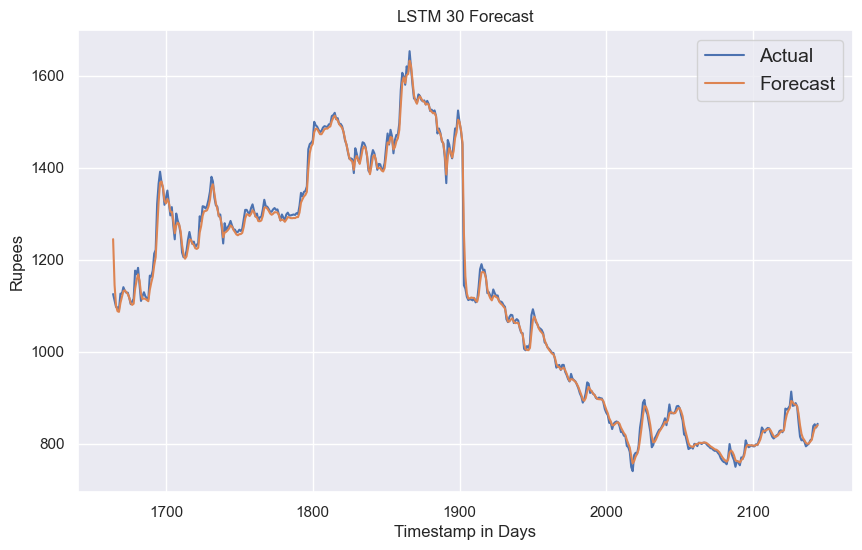

In [21]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.savefig('../Images/LSTM/LSTM FORECAST VS ACTUAL')
plt.show()

In [22]:
# calculate MAE
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

8.19907